In [4]:
from pulsar_analysis import pulsar_analysis
from generic_plotting import *

In [5]:
class PulsarAnalysis_update(pulsar_analysis):
    def load_data(self,skiprows=1):
        if self.data_type == 'ascii':
            #also skip first few lines
            self.raw_data = np.loadtxt(self.file_path, skiprows=skiprows)
            self.n_channels = self.raw_data.shape[1]

        elif self.data_type == 'swan':
            dt = np.dtype([
                ('header', 'S8'), ('Source', 'S10'),
                ('Attenuator_1', '>u1'), ('Attenuator_2', '>u1'),
                ('Attenuator_3', '>u1'), ('Attenuator_4', '>u1'),
                ('LO', '>u2'), ('FPGA', '>u2'),
                ('GPS', '>u2'), ('Packet', '>u4'),
                ('data', '>i1', 1024)
            ])
            self.memmap_file = np.memmap(self.file_path, dtype=dt, mode='r')
            self.data_blocks = self.memmap_file['data']

            reshaped = self.data_blocks.reshape(-1)
            ch0 = (reshaped[0::2].astype(np.int32))
            ch1 = (reshaped[1::2].astype(np.int32))
            self.raw_data = np.stack([ch0, ch1], axis=1)
            self.n_channels = 2
        else:
            raise ValueError("Unsupported data type. Use 'ascii' or 'swan'.")        
        print(f"Given Data is of ndim : {self.raw_data.ndim} . shape : {self.raw_data.shape[1]}")
        self.n_channels = self.raw_data.shape[1]



In [ ]:
# Initialize and run the analysis
long_data = "./Data4Analysis/ch00_B0833-45_20150612_191438_010_4.txt"
short_data = "/home/ashwin-ubuntu/GIT/Vela_Data_analysis/Analysis/vela_chunks/chunk_0001.txt"

crab_file = "./Data4Analysis/Crab/ch05_CRAB_20090725_095307_000.txt"
crab = PulsarAnalysis_update(crab_file, channel_names=["N", "S"], data_type='ascii',block_size=512, avg_blocks=60, sample_rate=33e6)
crab.bandwidth_MHZ = 46
crab.center_freq_MHZ =  425

crab.compute_intensity_matrix()

Given Data is of ndim : 2 . shape : 2
file_path: ./Data4Analysis/Crab/ch05_CRAB_20090725_095307_000.txt
data_type: ascii
n_channels: 2
raw_data shape :  (33000447, 2)
channel_names: ['N', 'S']
block_size: 512
avg_blocks: 60
sample_rate: 33000000.0
intensity_matrix_ch_s shape :  (2,)
dedispersed_ch_s shape :  (2,)
dedispersed_choped_ch_s: [None None]
folded_ch_s: [None None]
center_freq_MHZ: 326.5
bandwidth_MHZ: 16.5


In [24]:

def plot_intensity_matrix(self, channel, gamma=2.5, dedispersed=False,choped=False):
    try:
        if dedispersed:
            if choped:
                matrix = self.dedispersed_choped_ch_s[channel]
                title_suffix = " (Dedispersed and Choped)"
            else:
                matrix = self.dedispersed_ch_s[channel]
                title_suffix = " (Dedispersed)"
        else:
            matrix = self.intensity_matrix_ch_s[channel]
            title_suffix = ""
    except:
        raise ValueError("Requested intensity / Desispersed matrix not computed.")

    num_segments, n_freq = matrix.shape
    time_bin_us = (self.block_size * self.avg_blocks / self.sample_rate) * 1e6
    time_extent_ms = num_segments * time_bin_us / 1000

    # Frequency axis
    bandwidth = self.bandwidth_MHZ #16.5  # MHz
    center_freq = self.center_freq_MHZ # 326.5  # MHz
    freq_array = np.linspace(center_freq + bandwidth / 2, center_freq - bandwidth / 2, n_freq)

    plt.figure(figsize=(10, 6))
    plt.imshow(np.log(matrix.T[:,600:900]), aspect='auto', origin='upper', cmap='turbo',
                norm=colors.PowerNorm(gamma=gamma),
                extent=(0, time_extent_ms, freq_array[-1], freq_array[0]))
    plt.colorbar(label="Log Power")
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency (MHz)")
    plt.title(f"Dynamic Spectrum (Channel {channel}){title_suffix}")
    yticks = np.linspace(freq_array[0], freq_array[-1], 8)
    plt.yticks(yticks)
    plt.show()

In [30]:
matrix = vela.intensity_matrix_ch_s[1]

print(f"Shape of intensity matrix for channel 1 : {matrix.shape}")

Shape of intensity matrix for channel 1 : (1074, 257)


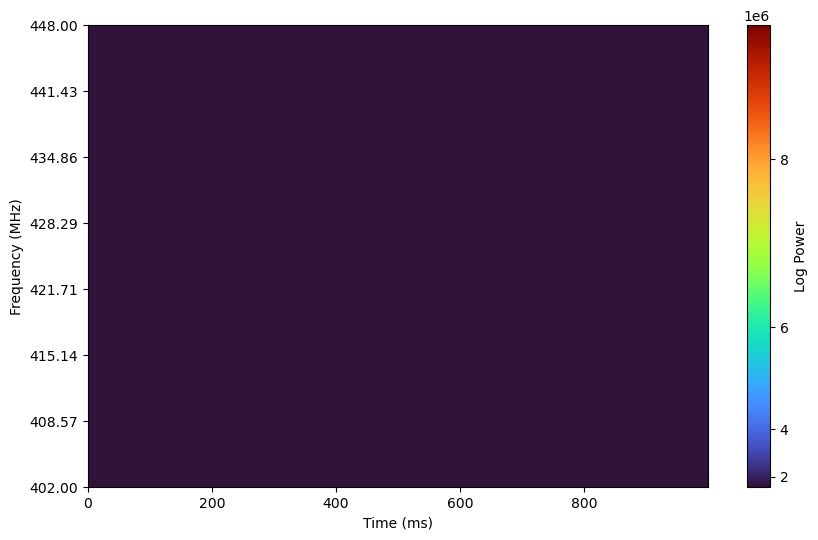

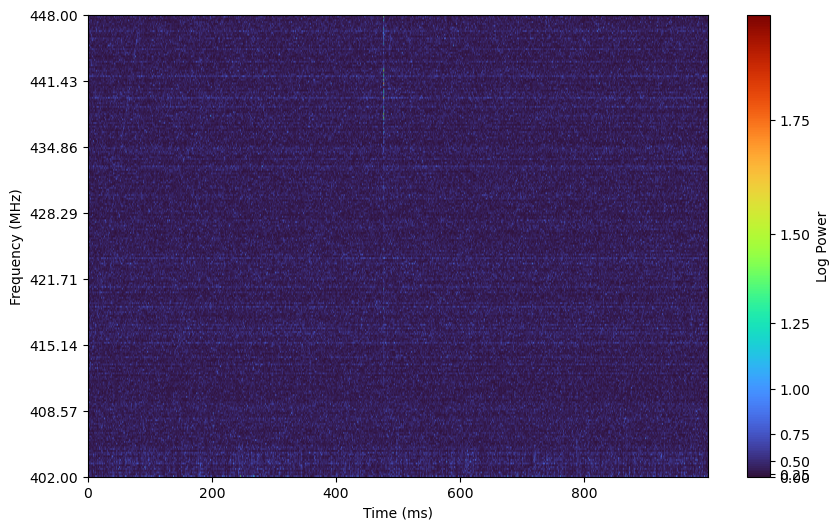

In [28]:
def anti_line_noise_median(mat):
    norm = np.median(mat, axis=0)
    mat = mat / norm
    mat = mat - np.min(mat, axis=0)
    return mat

vela = crab
matrix = vela.intensity_matrix_ch_s[1]
# Now you can plot or analyze `folded`
plot_intensity_matrix_single(matrix, vela.block_size, vela.avg_blocks, vela.sample_rate, vela.bandwidth_MHZ, vela.center_freq_MHZ, gamma=2.5)
plot_intensity_matrix_single( anti_line_noise_median(matrix), vela.block_size, vela.avg_blocks, vela.sample_rate, vela.bandwidth_MHZ, vela.center_freq_MHZ, gamma=2.5)


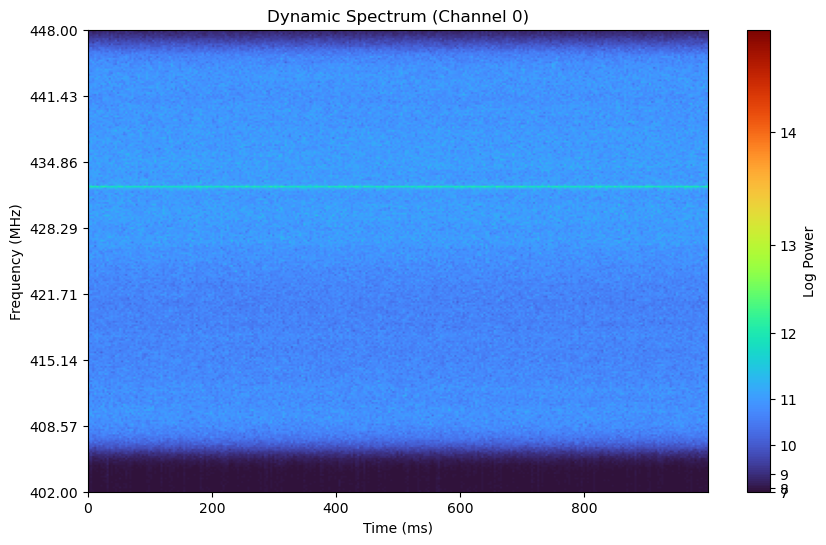

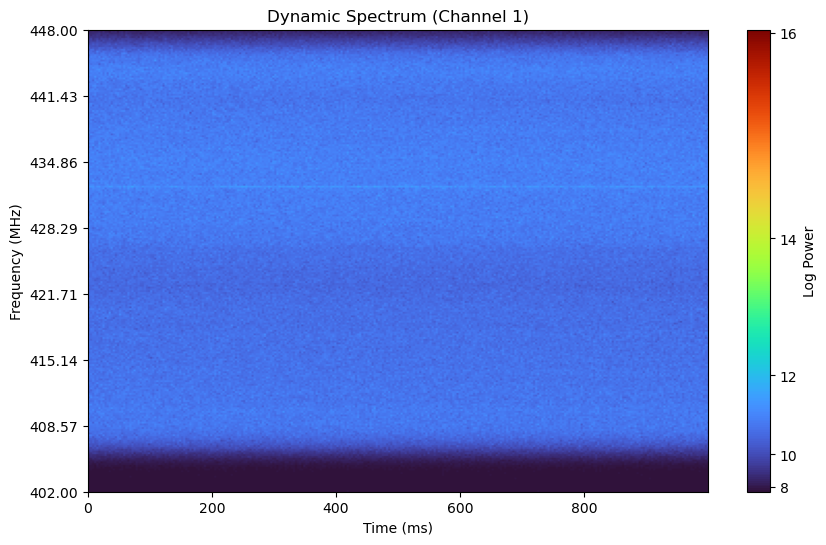

In [25]:
plot_intensity_matrix(crab,channel = 0)
plot_intensity_matrix(crab,channel = 1)

In [ ]:
vela.block_size = 128
vela.avg_blocks = 100

vela.compute_intensity_matrix()
plot_intensity_matrix(vela,channel = 0)
plot_intensity_matrix(vela,channel = 1)